In [1]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
#import regions
import numpy as np
from astropy import coordinates
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import QTable, Table, Column
import matplotlib.cm as cm
from pyregion.mpl_helper import properties_func_default
from astropy.visualization import simple_norm
from astropy.stats import mad_std
#from regions import DS9Parser #depreciated
import re
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import warnings
from astropy import visualization
from astropy.io import ascii
# from astropy.table import Table
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp

from gaussfit_catalog import gaussfit_catalog
import pandas as pd
from astropy.table import vstack

import numpy as np
import astropy.constants as c
import astropy.units as u

from radio_beam import Beam

from dendrocat import RadioSource

from astropy.stats import sigma_clip
from regions import Regions
from regions import PixCoord, CirclePixelRegion, CircleAnnulusPixelRegion
from astropy.nddata.utils import Cutout2D

In [2]:
cd /orange/adamginsburg/sgrb2/NB/the_end

/orange/adamginsburg/sgrb2/NB/the_end


In [3]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
        hdr = fh[0].header
    datas=fh[0].data #
    return datas, wcs, hdr

In [4]:
def basefigure(datas, wcs_out):
    """
    Set up basefigure for plotting the datas. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot()
    im = ax.imshow(datas, cmap='gray_r', norm=norm1,origin='lower')
    return fig, ax

In [5]:
def create_regions(datas, num, fldconf):
    size = np.array(datas.shape)
    im_center = size/2
    #center = PixCoord(im_center[0],im_center[1])
    center = PixCoord(im_center[1], im_center[1]) # Using [1] for both values to deal with Band3 cut data.
    middle_row = datas[int(im_center[1])]
    # DANGER!!!!!!!!!
    if fldconf == 'NB3':
        center = PixCoord(im_center[1], 1372.0)
        middle_row = datas[int(1372.0)]
    diameter = len(middle_row[~np.isnan(middle_row)])
    region_rad = (((diameter/2)/int(num)))
    
    region_list = []
    region_list += [CirclePixelRegion(center,region_rad)]
    inner_radius = region_rad
    outer_radius = inner_radius+region_rad
    for i in range(int(num)-1):
        region_list += [CircleAnnulusPixelRegion(center,inner_radius,outer_radius)]
        inner_radius = outer_radius
        outer_radius = inner_radius+region_rad
    #regions.write_ds9(region_list, 'regions_15rings_test.reg')
    return region_list

In [6]:
def set_up_regions(path,wX):
    """
    # I am pretty sure "regionsX" part can be cut from this function
    Modifies a CASA-created DS9 region file to a version that works with Astrodendro package. (and also .contains?)
    Adds 'source_X' text to each region, where X is a source number based on its RA.
    
    Outputs:
    includeX: original DS9 regions
    regionsX: modified version of DS9 regions that works with Astrodendro
    pixelX: same as regionsX, but with pixel coordinates.
    """
    includeX = Regions.read(path)
    strX = Regions.serialize(includeX, format='ds9')
    start = []
    for m in re.finditer('source=1', strX):
        start += [m.end()]
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        strM = strX[:loc] + ' text={source_' + x +'}' + strX[loc:]
    parser = Regions.parse(strX, format='ds9')
    regionsX = parser.serialize(format='ds9')
    #regions.write_ds9(regionsX, 'regions_15_rings_test.reg')
    pixelX = [region.to_pixel(wX) for region in includeX]
    return includeX, regionsX, pixelX

In [7]:
def get_noise_regions(data, RMS, create_regions_out):
    all_regs = create_regions_out
    masks = [reg.to_mask() for reg in all_regs]
    masked_1d = [m.get_values(data) for m in masks]
    rmss = [sigma_clip(m,sigma=7).std() for m in masked_1d]
    
    rmss_adj=rmss[:]
    lowest = np.min(rmss)
    for i in range(len(rmss)):
        if rmss[i] > lowest:
            rmss_adj[i] = lowest
        else:
            break
            
    rmss_adj = np.array(rmss_adj)*RMS
    min_values = []
    [min_values.append(x) for x in rmss_adj if x not in min_values]
    min_values = rmss_adj[:]
    
    return min_values

In [8]:
# def run_dendros(datas, min_values, RMS, min_delta_factor, min_npix):
#     dendros = []
#     for i in range(len(min_values)):
#         if min_values[i] == min_values[i-1]:
#             dendros.append(dndr)
#         else:
#             if i == 0:
#                 min_delta = (min_values[i]/RMS)*100
#                 dndr = Dendrogram.compute(datas, min_value = min_values[i], min_delta = min_delta, min_npix = min_npix)
#                 dendros.append(dndr)
#             else:
#                 min_delta = (min_values[i]/RMS)*min_delta_factor
#                 dndr = Dendrogram.compute(datas, min_value = min_values[i], min_delta = min_delta, min_npix = min_npix)
#                 dendros.append(dndr)
#     return dendros 

In [9]:
def run_dendros(datas, min_values, RMS, min_delta_factor, min_npix):
    dendros = []
    min_delta = (min_values[0]/RMS)*5
    dndr = Dendrogram.compute(datas, min_value = min_values[0], min_delta = min_delta, min_npix = min_npix)
    dendros.append(dndr)

    temp_min_values = min_values[1:]
    for i in range(len(temp_min_values)):
        if temp_min_values[i] == temp_min_values[i-1]:
            dendros.append(dndr)
        else:
            min_delta = (temp_min_values[i]/RMS)*min_delta_factor
            dndr = Dendrogram.compute(datas, min_value = temp_min_values[i], min_delta = min_delta, min_npix = min_npix)
            dendros.append(dndr)
    return dendros 

In [29]:
def set_up_catalog(d, wX, hdrX, includeX, extendedX, central=True):
    """
    Creates a dendrogram catalog.
    Removes sources that are not inside includeX regions.
    Removes sources inside extendedX regions.
    Removes sources that are above level 5 in the dendrogram (removes some unwated 
    detections from extended structures).
    """
    
    my_beam = Beam.from_fits_header(hdrX)  
    scale = wX.proj_plane_pixel_scales()[0]
    
    cat = pp_catalog(d.leaves,metadata={'data_unit':u.Jy / u.beam,'beam_major':my_beam.major,'beam_minor':my_beam.minor,'beam_pa':my_beam.pa, 'wcs': wX, 'spatial_scale':scale},verbose=False)
    
    peaks = []
    peak_x_px = []
    peak_y_px = []
    peak_x_wcs = []
    peak_y_wcs = []
    npix = []
    for i in range(len(d.leaves)):
        (y, x), peak = d.leaves[i].get_peak()
        peak_x_px += [x] # x 
        peak_y_px += [y] # y 
        peaks += [peak]
        npix += [d.leaves[i].get_npix()]
        
        coordsX_peak_wcs = PixCoord(x,y).to_sky(wX)
        peak_x_wcs += [coordsX_peak_wcs.ra.deg]
        peak_y_wcs += [coordsX_peak_wcs.dec.deg]
        
        
    cat.add_column(peaks,name='peak',index=4)
    cat.add_column(peak_x_px, name = 'x_peak_px', index=5)
    cat.add_column(peak_y_px, name = 'y_peak_px', index=6)
    cat.add_column(peak_x_wcs, name = 'x_peak', index=7)
    cat.add_column(peak_y_wcs, name = 'y_peak', index=8)
    cat.add_column(npix,name='npix',index=9)

    print('Total detections: '+str(len(d.leaves)))
    purgeX = []
    for i in range(len(d)):
        if d[i].level > 5: 
            purgeX += [d[i].idx]
    coordsX_wcs = coordinates.SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    containsX = np.zeros(len(cat),dtype=bool)

    coordsX_pix = PixCoord.from_sky(coordsX_wcs, wX)
    containsX[includeX.contains(coordsX_pix)] = 1

    print('Total detections inside input regions: '+str(np.sum(containsX)))
    cat_cut_temp = cat[containsX]
    cat_coords_temp = coordinates.SkyCoord(cat_cut_temp['x_cen'], cat_cut_temp['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    
    ####
    containsX1 = np.zeros(len(cat_cut_temp),dtype=bool)
    for X in extendedX:
        containsX1[X.contains(cat_coords_temp, wX)] = 1

    print('Total detections within extended structures (removed): '+str(np.sum(containsX1)))
    cat_cut = cat_cut_temp[~containsX1]
    
    ####
    
    if central:
        print('Central region. No trimming performed')
        cat_coords = coordinates.SkyCoord(cat_cut['x_cen'], cat_cut['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_cut, cat_cut['_idx']
    else:
        cat_final= cat_cut[:0].copy()
        for i in range(len(cat_cut)):    
            if cat_cut['_idx'][i] not in purgeX:
                cat_final.add_row(cat_cut[i])
        print('Total detections after triming above level 5: '+str(len(cat_final)))
        cat_coords = coordinates.SkyCoord(cat_final['x_cen'], cat_final['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_final, cat_final['_idx']

In [12]:
# This creates list instead of astropy tables
def catalog_from_rings(dendros, wcs_, hdr, all_regs, extended):
    cat_coords = []
    cat_final = []
    IDs = []
    concentric_ID = []
    for i in range(len(dendros)):
        if i == 0:
            cat_coords, cat_final, IDs = set_up_catalog(dendros[i],wcs_,hdr, all_regs[i], extended)
            #wcs_coords_, wcs_ = set_up_catalog(dendros[i],wcs,hdr, all_regs[i], extended)
            #return wcs_coords_, wcs_
        ########################
            #cat_coords, cat_final, IDs = set_up_catalog(dendros[i],wcs_,hdr, all_regs[i])
            concentric_ID = [i] * len(cat_final)
        else:
            x,y,z = set_up_catalog(dendros[i],wcs_,hdr,all_regs[i], extended)
            CID = [i] * len(y)
            try:
                cat_coords = vstack([cat_coords,x])
                cat_final = vstack([cat_final,y])
                IDs = vstack([IDs])
                concentric_ID = vstack([concentric_ID,CID])
            except:
                pass
    return cat_coords, cat_final, IDs, concentric_ID

In [13]:
# sandbox

In [14]:
path = 'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
datas, wcs_, hdr = read_in(path)

In [15]:
#path = 'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
path = 'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits'
datas, wcs_, hdr = read_in(path)
#NB3:
position = (3072, 3922)
size = (4444, 6144)
#MB3:
#position = (3072, 2135)
#size = (4270, 6144)

cutout = Cutout2D(datas, position, size, wcs_)
datas = cutout.data
wcs_ = cutout.wcs

In [16]:
path = 'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor.fits'
#path = 'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor.fits'
datas, wcs_, hdr = read_in(path)

In [17]:
mad1 = mad_std(datas, ignore_nan=True)
norm1 = visualization.simple_norm(datas, stretch='linear', min_cut=-10*mad1, max_cut=20*mad1,)

In [18]:
#cat_final.add_column(concentric_ID['col0'],name='c_ID', index = 1) # added .data, check if it worked.

In [19]:
def add_pix_coords(cat, wcs):
    xwcs = np.array(cat['x_cen'])
    ywcs = np.array(cat['y_cen'])
    
    c_wcs = SkyCoord(xwcs, ywcs, unit="deg", frame="icrs")
    c_pix = wcs.world_to_pixel(c_wcs)
    
    cat.add_column(c_pix[0],name='x_cen_px')
    cat.add_column(c_pix[1],name='y_cen_px')

In [20]:
def get_radius(datas, cat, wcs_, fldconf):
    # maybe add physical units
    xc, yc = datas.shape[1]/2, datas.shape[1]/2 # careful with datas variable here
    if fldconf == 'NB3':
        xc, yc = datas.shape[1]/2, 1372.0
    x = cat['x_cen_px']
    y = cat['y_cen_px']
    radius_px = np.sqrt((x - xc)**2 + (y - yc)**2)

    # This is really messy and probably doesn't work correctly
    temp_sky_coords = SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), distance=8.5*u.kpc, frame='icrs')
    c1= temp_sky_coords
    xc_wcs =  wcs_.pixel_to_world(xc, yc).ra
    yc_wcs =  wcs_.pixel_to_world(xc, yc).dec
    center_sky_coords = SkyCoord(xc_wcs, yc_wcs, distance = 8.5*u.kpc, frame = 'icrs')
    c2 = center_sky_coords
    sep = c1.separation_3d(c2).to(u.AU)
    
    return radius_px, sep

In [21]:
def add_columns(datas, cat, wcs_, concentric_ID, fldconf):
    cat.add_column(concentric_ID['col0'],name='c_ID', index = 1)
    add_pix_coords(cat, wcs_)
    radius_px, radius_AU = get_radius(datas, cat, wcs_, fldconf)
    cat.add_column(radius_px, name='radial_d_px')
    cat.add_column(radius_AU, name='radial_d_AU')
    if not '_name' in cat.colnames:
        fwhm_maj = cat['major_sigma']*np.sqrt(8*np.log(2))
        fwhm_min = cat['minor_sigma']*np.sqrt(8*np.log(2))
        cat.add_column(fwhm_maj,index=11,name='major_fwhm')
        cat.add_column(fwhm_min,index=12,name='minor_fwhm')
        #cat.add_column(cat['_idx'],index=1,name='_name')
        cat.add_column(0.0,name='rejected')
        numbered = list(range(1, len(cat)+1))
        cat.add_column(numbered, name = '_name', index = 2)

In [22]:
# def regions_gaussfit(cat_final, fldconf):
#     """
#     Creates a DS9 region file from the catalog. The centers and sizes of each region
#     are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
#     """
#     centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
#     # There are some problems with displaying these regions in DS9.
#     # Use 1st option to display the regions in DS9.
#     # Use 2nd option to have proper radii for later use.
#     #radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
#     #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    
#     # fixed stuff?
#     radiusX = Angle(cat_final['radius'][::-1].value, unit='deg')
#     cat_regionsX = []
#     for i in range(len(centerX)):
#         cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
#     str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX, coordsys='icrs')
#     start = []
#     for m in re.finditer('\)', str_cat_regionsX):
#         start += [m.end()]
#     str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
#     str2 = '}'
#     for i in range(len(start)):
#         loc = start[-1-i]
#         x = str(i+1)
#         str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
#     parser = DS9Parser(str_cat_regionsX)
#     str_cat_regionsX = parser.shapes.to_regions()
#     #regions.write_ds9(str_cat_regionsX, "regions_5RMS_2npix_0.5mindelta_7rings_"+fldconf+"_text_deg.reg")
#     return str_cat_regionsX

In [23]:
def regions_gaussfit(cat_final, fldconf):
    """
    Creates a DS9 region file from the catalog. The centers and sizes of each region
    are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
    """
    centerX = SkyCoord(cat_final['x_cen'][::-1], cat_final['y_cen'][::-1],unit='deg')
    # There are some problems with displaying these regions in DS9.
    # Use 1st option to display the regions in DS9.
    # Use 2nd option to have proper radii for later use.
    #radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    
    # fixed stuff?
    radiusX = Angle(cat_final['radius'][::-1].value, unit='deg') #### IMPORTANT!!! ONLY RADIUS IS BACKWARDS, X_CEN AND Y_CEN ARE NOT???
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    #str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX, coordsys='icrs') # regions 0.5
    str_cat_regionsX = Regions(cat_regionsX).serialize(format='ds9')
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    #parser = DS9Parser(str_cat_regionsX) #regions 0.5
    parser = Regions.parse(str_cat_regionsX, format='ds9')
    #str_cat_regionsX = parser.shapes.to_regions()
    #regions.write_ds9(str_cat_regionsX, ''.reg")
    #return str_cat_regionsX
    return parser

In [35]:
def catalog_for_configuration(fldconf, RMS = 5.0, num_regions = 7, min_delta_factor = 0.5, min_npix = 3):
    if fldconf == 'NB3':
        #path = 'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal3.image.tt0.pbcor.fits'
        path = 'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits'
        position = (3072, 3922)
        size = (4444, 6144)
    if fldconf == 'MB3':
        path = 'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
        position = (3072, 2135)
        size = (4270, 6144)
    if fldconf == 'NB6':
        path = 'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor.fits'
    if fldconf == 'MB6':
        path = 'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor.fits'

    datas, wcs_, hdr = read_in(path)

    if fldconf == 'NB3' or fldconf == 'MB3':
        cutout = Cutout2D(datas, position, size, wcs_)
        datas = cutout.data
        wcs_ = cutout.wcs
    
    regions_rings = create_regions(datas, num_regions, fldconf) # number of rings
    min_values = get_noise_regions(datas, RMS, regions_rings)
    
    extended, regions_, pixel_ = set_up_regions(fldconf+'_extended_structures.reg',wcs_)
    
    print('Running dendrograms')
    dendros = run_dendros(datas, min_values, RMS, min_delta_factor, min_npix)
    print('Finished running dendrograms')
    
    print('Getting catalog')
    cat_coords, cat_final, IDs, concentric_ID = catalog_from_rings(dendros, wcs_, hdr, regions_rings, extended)  # is IDs really needed?
    print('Done cataloging')
    
    #newly added:
    if np.min(cat_final['minor_sigma']) == 0:
        print('Spotted "1D" sources')
        print('Length before'+ str(len(cat_final)))
        concentric_ID = concentric_ID[cat_final['minor_sigma']>0]
        cat_final = cat_final[cat_final['minor_sigma']>0]

        print('Length after'+ str(len(cat_final)))

    add_columns(datas, cat_final, wcs_, concentric_ID, fldconf)
    
    # This is to fix the pixel coordinates being recorded based on the cut image
    if fldconf == 'NB3':
        cat_final['y_cen_px'] = cat_final['y_cen_px']+1700
        cat_final['y_peak_px'] = cat_final['y_peak_px']+1700
    
    catalogname='catalog_'+fldconf+'_'+str(int(RMS))+'RMS_'+str(num_regions)+'rings_'+str(min_delta_factor)+'mindelta'+str(min_npix)+'npix'+'.csv'
    ###############################ascii.write(cat_final, catalogname, format='csv', overwrite=True)

    str_cat_regionsX = regions_gaussfit(cat_final, fldconf)
    regions_name = 'regions_'+fldconf+'_'+str(int(RMS))+'RMS_'+str(num_regions)+'rings_'+str(min_delta_factor)+'mindelta'+str(min_npix)+'npix'+'.reg'
    ###############################regions.write_ds9(str_cat_regionsX, regions_name, overwrite=True)
    
    return cat_final

In [33]:
cat_final_NB3 = catalog_for_configuration('NB3', RMS = 10.0, num_regions = 7, min_delta_factor = 1.0, min_npix = 3)

Running dendrograms
Finished running dendrograms
Getting catalog
Total detections: 205
Total detections inside input regions: 94
Total detections within extended structures (removed): 17
Central region. No trimming performed
Total detections: 1073
Total detections inside input regions: 113
Total detections within extended structures (removed): 77
Central region. No trimming performed
Total detections: 1073
Total detections inside input regions: 22
Total detections within extended structures (removed): 2
Central region. No trimming performed
Total detections: 1073
Total detections inside input regions: 5
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 420
Total detections inside input regions: 3
Total detections within extended structures (removed): 1
Central region. No trimming performed
Total detections: 190
Total detections inside input regions: 19
Total detections within extended structures (removed): 17
Central region

In [34]:
cat_final_NB3

_idx,c_ID,_name,area_ellipse,area_exact,flux,peak,x_peak_px,y_peak_px,x_peak,y_peak,npix,major_fwhm,minor_fwhm,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,x_cen_px,y_cen_px,radial_d_px,radial_d_AU,rejected
,,,deg2,deg2,Jy,,,,,,,deg,deg,deg,deg,deg,deg,,,,,,AU,
int64,int64,int64,float64,float64,float64,float32,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
17,0,1,7.880787316897891e-10,3.0000000000000004e-09,0.003526816470551393,0.001757356,3281,2752,266.83183456879163,-28.373435556673513,120,3.9706345672073514e-05,2.5271277715771765e-05,1.6861732494531935e-05,1.0731723542568886e-05,168.45135485561224,1.3451968316200687e-05,266.8318399822178,-28.373436616858044,3280.047376758536,2751.7879724545173,381.86313459261436,58425.0596012993,0.0
25,0,2,2.0206966167272837e-10,6.500000000000001e-10,0.0004761359896282949,0.00059594284,2961,2827,266.8336530190914,-28.37306056036838,26,2.0123363449643425e-05,1.2785509981736774e-05,8.545605636450638e-06,5.4295061776445575e-06,159.9642071775037,6.8116384662445855e-06,266.83365291491066,-28.373060096772413,2961.018332661269,2827.092719292432,268.8800971229747,41138.65486338743,0.0
26,0,3,2.6749882455088414e-10,8.500000000000002e-10,0.0005943756564012983,0.0005578423,3271,2842,266.8318914002301,-28.372985557154106,34,1.9424545166079217e-05,1.7534304004962156e-05,8.24884483511517e-06,7.4461333221459405e-06,151.77278478912172,7.83721879214575e-06,266.83189306621296,-28.372983571457635,3270.706833149118,2842.397142044582,303.6476213004927,46458.086063151706,0.0
27,0,4,7.136535243158894e-10,2.4500000000000004e-09,0.002292104377144017,0.0010100632,3108,2860,266.83281767073174,-28.37289556166737,98,4.60020398904779e-05,1.9752762274645606e-05,1.953526766835098e-05,8.388225807881636e-06,127.0685372757318,1.2801024819112626e-05,266.8328172401885,-28.37289984320904,3108.075763263876,2859.143691538321,215.891798702509,33031.445203394,0.0
30,0,5,1.7950951729016305e-10,5.500000000000001e-10,0.0006070391968135183,0.00081266527,3158,2934,266.8325335406748,-28.372525560948606,22,2.3663625767592383e-05,9.658811777295969e-06,1.004901661913676e-05,4.101719703668067e-06,118.15247052903791,6.420144038041601e-06,266.83253512718653,-28.3725217951516,3157.7208161497006,2934.753160531485,161.81703638822194,24758.006568524346,0.0
40,0,6,4.361149893602843e-10,1.6500000000000003e-09,0.0019200120947628586,0.0014818404,3056,2996,266.83311316718084,-28.37221556178985,66,2.5359056924741277e-05,2.189704079767812e-05,1.0768999940463809e-05,9.29881705563209e-06,99.25366323594758,1.0006945603853648e-05,266.8331117714504,-28.372215765055326,3056.2456148469487,2995.9593470858763,77.65553133651791,11881.296294513555,0.0
45,0,7,2.8063244855645707e-10,9.000000000000002e-10,0.0012259516832688025,0.0011371094,3064,3006,266.833067706369,-28.372165561812476,36,2.0987737976015865e-05,1.702510364159647e-05,8.91267170088151e-06,7.229895837485411e-06,60.37892023824572,8.027308890971945e-06,266.8330695940365,-28.372166475818524,3063.667816073414,3005.8171986632456,66.70523578975462,10205.901076561639,0.0
49,0,8,6.343700769454377e-10,1.9250000000000003e-09,0.007204871916909573,0.0033853918,3082,3025,266.83296541968963,-28.372070561808233,77,4.8981179656750025e-05,1.6490391303788e-05,2.0800391843150914e-05,7.002824414793559e-06,-166.8404712581909,1.2069030277387244e-05,266.8329513550558,-28.372070446332998,3084.4750389024566,3025.0230937346096,48.6051058828706,7436.581200359575,0.0


In [230]:
cat_final_MB3 = catalog_for_configuration('MB3', RMS = 10.0, num_regions = 7, min_delta_factor = 1.0, min_npix = 3)

6049
Running dendrograms
Finished running dendrograms
Getting catalog
Total detections: 562
Total detections inside input regions: 187
Total detections within extended structures (removed): 94
Central region. No trimming performed
Total detections: 562
Total detections inside input regions: 64
Total detections within extended structures (removed): 42
Central region. No trimming performed
Total detections: 562
Total detections inside input regions: 11
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 562
Total detections inside input regions: 8
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 283
Total detections inside input regions: 2
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 163
Total detections inside input regions: 19
Total detections within extended structures (removed): 7
Central regio

In [23]:
cat_final_NB6= catalog_for_configuration('NB6', RMS = 4.0, num_regions = 20, min_delta_factor = 0.5, min_npix = 3)

Running dendrograms
Finished running dendrograms
Getting catalog
Total detections: 153
Total detections inside input regions: 23
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 2614
Total detections inside input regions: 105
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 2614
Total detections inside input regions: 62
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 2614
Total detections inside input regions: 26
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 2614
Total detections inside input regions: 44
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 2614
Total detections inside input regions: 12
Total detections within extended structures (removed): 0
Central regio

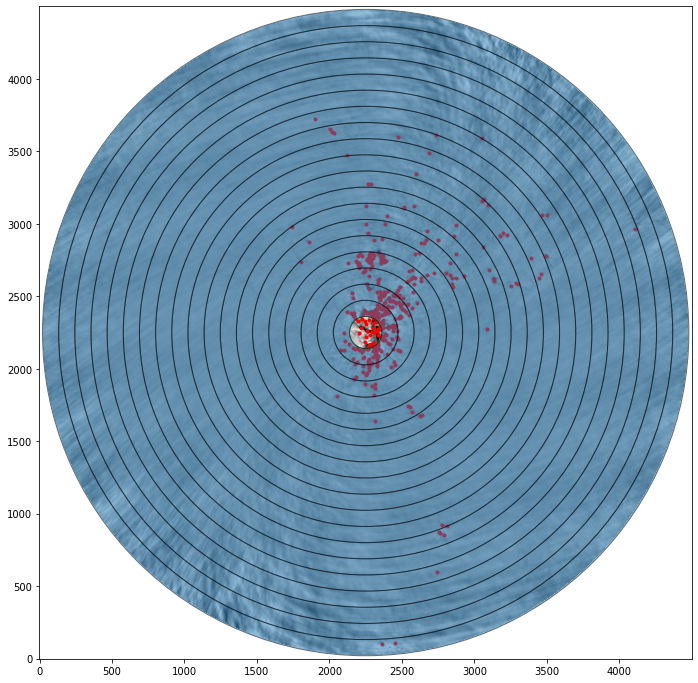

In [31]:
ig, ax = basefigure(datas, wcs_)
for i in range(len(create_regions_out)):
    create_regions_out[i].plot(ax=ax,alpha=0.5)
plt.scatter(cat_final_NB6['x_cen_px'],cat_final_NB6['y_cen_px'], marker='.', color='red')

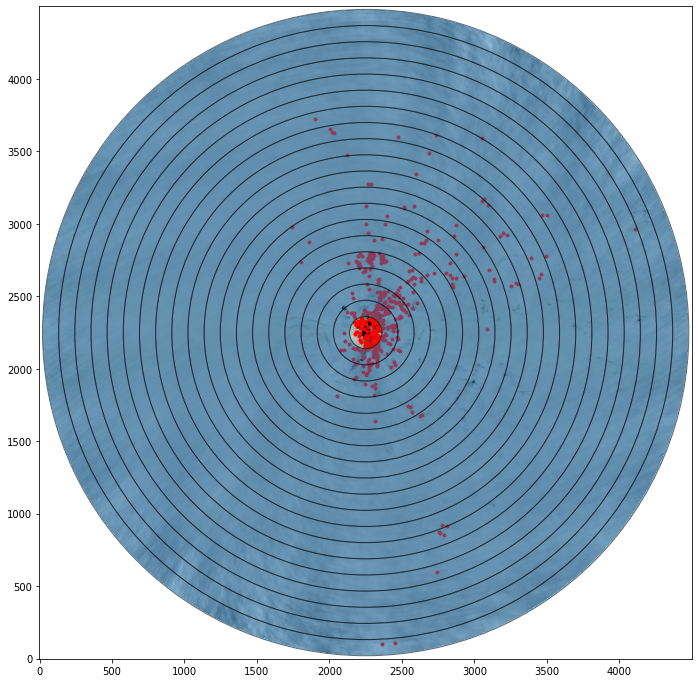

In [50]:
fig, ax = basefigure(datas, wcs_)
for i in range(len(create_regions_out)):
    create_regions_out[i].plot(ax=ax,alpha=0.5)
plt.scatter(cat_final_NB6['x_cen_px'],cat_final_NB6['y_cen_px'], marker='.', color='red')

In [53]:
cat_final_MB6= catalog_for_configuration('MB6', RMS = 5.0, num_regions = 20, min_delta_factor = 0.5, min_npix = 3)

Running dendrograms
Finished running dendrograms
Getting catalog
Total detections: 9
Total detections inside input regions: 5
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 9
Total detections inside input regions: 3
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 9
Total detections inside input regions: 1
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 9
Total detections inside input regions: 0
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 9
Total detections inside input regions: 0
Total detections within extended structures (removed): 0
Central region. No trimming performed
Total detections: 9
Total detections inside input regions: 0
Total detections within extended structures (removed): 0
Central region. No trimming performed

In [ ]:
cat_final_MB6

In [ ]:
# Save this for later: after catalog is reviewed. Otherwise this will have a lot of unwanted sources.

# def leaf_mask(cat_in,dX, hdrX, Xcal):
#     maskX = np.zeros(Xcal.shape, dtype=bool)
#     for i in range(len(dX.leaves)):
#         if dX.leaves[i].idx in cat_in['_idx']:
#             maskX = maskX | dX.leaves[i].get_mask()

#     maskX_hdu = fits.PrimaryHDU(maskX.astype('short'), hdrX)
#     return maskX_hdu

# maskN = leaf_mask(cat_finalN, dN, hdrN, Ncal)
# maskN.writeto('maskN6.fits',overwrite=True)

In [244]:
regions_gaussfit(cat_final_NB3, 'NB3')
#regions_gaussfit(cat_final_MB3, 'MB3')
#regions_gaussfit(cat_final_NB6, 'NB6')
#regions_gaussfit(cat_final_MB6, 'MB6')

In [9]:
def create_images(cat, path, fldconf):
    if fldconf == 'NB3' or fldconf == 'MB3':
        frq = 100.0
    else:
        frq = 225.0
    fits.setval(path, 'FREQ_ID', value=frq)
    fits.setval(path, 'CTYPE3', value='FREQ')
    fits.setval(path, 'CUNIT3', value='GHz')
    fits.setval(path, 'CRVAL3', value=frq)
    fits.setval(path, 'SPECSYS', value='TOPOCENT')
    
    source_object = RadioSource(fits.open(path))

    with fits.open(path, 'update') as f:
        for hdu in f:
            hdu.header.remove('SPECSYS')
            hdu.header.remove('FREQ_ID')
            hdu.header.remove('CTYPE3')
            hdu.header.remove('CUNIT3')
            hdu.header.remove('CRVAL3')

    
    RadioSource.plot_grid(source_object,catalog=cat,singles=True,outfile = fldconf+'_images_4RMS/'+ fldconf +'_img')
    
    return source_object

In [22]:
MB3_cat = ascii.read('catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final.csv')
NB3_cat = ascii.read('catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final.csv')
MB6_cat = ascii.read('catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final.csv')
NB6_cat = ascii.read('catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final.csv')

In [30]:
def fix_cat(cat):
    for i in range(len(cat)):
        cat['_name'][i] = cat['_name'][i]+1

In [176]:
def remove_1D(cat):
    #cat = cat[cat['area_exact']>7.500000000000001e-11]	
    return cat[cat['minor_fwhm']!=0]

In [177]:
MB3_cat = remove_1D(MB3_cat)
MB3_cat = MB3_cat[MB3_cat['area_exact']>7.500000000000001e-11]	
NB3_cat = remove_1D(NB3_cat)
MB6_cat = remove_1D(MB6_cat)
MB6_cat = MB6_cat[MB6_cat['area_exact']>2.314814814815185e-11]	
NB6_cat = remove_1D(NB6_cat)

In [58]:
ascii.write(MB3_cat, 'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final.csv', format='csv', overwrite=True)
ascii.write(NB3_cat, 'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final.csv', format='csv', overwrite=True)
ascii.write(MB6_cat, 'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final.csv', format='csv', overwrite=True)
ascii.write(NB6_cat, 'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final.csv', format='csv', overwrite=True)

In [13]:
def regions_gaussfit(cat_final, fldconf):
    """
    Creates a DS9 region file from the catalog. The centers and sizes of each region
    are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
    """
    centerX = SkyCoord(cat_final['x_cen'][::-1], cat_final['y_cen'][::-1],unit='deg')
    # There are some problems with displaying these regions in DS9.
    # Use 1st option to display the regions in DS9.
    # Use 2nd option to have proper radii for later use.
    #radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    
    # fixed stuff?
    radiusX = Angle(cat_final['radius'][::-1].value, unit='deg') #### IMPORTANT!!! ONLY RADIUS IS BACKWARDS, X_CEN AND Y_CEN ARE NOT???
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    #str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX, coordsys='icrs') # regions 0.5
    str_cat_regionsX = Regions(cat_regionsX).serialize(format='ds9')
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    #parser = DS9Parser(str_cat_regionsX) #regions 0.5
    parser = Regions.parse(str_cat_regionsX, format='ds9')
    #str_cat_regionsX = parser.shapes.to_regions()
    #regions.write_ds9(str_cat_regionsX, ''.reg")
    #return str_cat_regionsX
    return parser

In [ ]:
# testing 

In [ ]:
# end testing 

In [15]:
MB3_cat_reg = regions_gaussfit(MB3_cat, 'MB3')
NB3_cat_reg = regions_gaussfit(NB3_cat, 'NB3')
MB6_cat_reg = regions_gaussfit(MB6_cat, 'MB6')
NB6_cat_reg = regions_gaussfit(NB6_cat, 'NB6')

In [21]:
#regions.write_ds9(MB3_cat_reg, 'regions_MB3_4RMS_30.0rings_0.7mindelta3npix_test.reg', overwrite=True, coordsys='icrs')
#regions.write_ds9(NB3_cat_reg, 'regions_NB3_4RMS_30.0rings_0.7mindelta3npix.reg', overwrite=True)
#regions.write_ds9(MB6_cat_reg, 'regions_MB6_4RMS_30.0rings_0.7mindelta3npix.reg', overwrite=True)
#regions.write_ds9(NB6_cat_reg, 'regions_NB6_4RMS_30.0rings_0.7mindelta3npix.reg', overwrite=True)
#MB3_cat_reg.write('regions_MB3_4RMS_30.0rings_0.7mindelta3npix_test_with_new_writer.reg', format='ds9', overwrite=True)

In [17]:
MB3_cat_reg.write('regions_MB3_4RMS_30.0rings_0.7mindelta3npix_test_with_final.reg', format='ds9', overwrite=True)
NB3_cat_reg.write('regions_NB3_4RMS_30.0rings_0.7mindelta3npix_test_with_final.reg', format='ds9', overwrite=True)
MB6_cat_reg.write('regions_MB6_4RMS_30.0rings_0.7mindelta3npix_test_with_final.reg', format='ds9', overwrite=True)
NB6_cat_reg.write('regions_NB6_4RMS_30.0rings_0.7mindelta3npix_test_with_final.reg', format='ds9', overwrite=True)

In [24]:
np.sum(MB3_cat['_name'])

64971

In [21]:
MB3_cat

_idx,c_ID,_name,area_ellipse,area_exact,flux,peak,npix,major_fwhm,minor_fwhm,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,x_cen_px,y_cen_px,radial_d_px,radial_d_AU,rejected,100.0GHz_snr
int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
941,0,0,9.113530739610145e-10,3.2250000000000003e-09,0.015264973732168265,0.005653016269207001,129,4.1502301268614775e-05,2.795966711985743e-05,1.762440461477782e-05,1.1873377406845523e-05,105.63457894981724,1.4465863526323167e-05,266.8338108589449,-28.38511168227036,3115.7927087407616,2982.3314207102258,99.79105897173206,15268.032022654985,0.0,28.912640051130776
951,0,1,1.0264472348167841e-09,1.0075000000000001e-08,0.1595143384253843,0.08008609712123871,403,3.771986813279909e-05,3.46484631233892e-05,1.6018153154587802e-05,1.4713847538584978e-05,-141.28073667494058,1.53521550072395e-05,266.8340751794522,-28.384996254144223,3069.2843424188454,3005.417090979457,66.63826655710653,10195.654783262353,0.0,301.0792404313873
956,0,2,7.703065025717809e-10,2.0750000000000004e-09,0.0060525787305992385,0.00238540256395936,83,5.319656543864369e-05,1.8437306813217034e-05,2.2590501363744136e-05,7.829603307532025e-06,136.4483858217243,1.3299423453532782e-05,266.833878957661,-28.38504390588987,3103.8104585142537,2995.8867181680093,82.49325391886961,12621.467849791314,0.0,7.082457650078901
976,0,3,1.00978224826943e-09,3.2000000000000005e-09,0.0017340863365012172,0.0005110484780743718,128,4.4717174560375485e-05,2.8752187309033435e-05,1.8989635600705857e-05,1.2209929743763306e-05,164.14553470869066,1.5227019292832233e-05,266.8337884105155,-28.384954895311775,3119.7426798604693,3013.688803901498,75.3628494067018,11530.515959185921,0.0,3.567233673525352
980,0,4,2.0161034980787117e-09,7.475e-09,0.01120607321311016,0.002279166132211685,299,5.76282814226749e-05,4.454455936012462e-05,2.4472477862705425e-05,1.8916332674388786e-05,69.437231953366,2.1515797280546006e-05,266.83395692244784,-28.384912521599762,3090.0922227810534,3022.1635923312465,53.01882735864175,8111.880586337012,0.0,16.900368264066227
992,0,5,4.250840667671987e-10,2.3000000000000003e-09,0.008732593311667723,0.00767515879124403,92,2.619168262262213e-05,2.0664692142725018e-05,1.1122583518808926e-05,8.775486766528447e-06,138.300605966283,9.879579165071512e-06,266.83364508127164,-28.38482823156954,3144.9622192662755,3039.0214805783853,80.06914626435004,12250.579378359278,0.0,43.06132798561846
1010,0,6,4.6256085792664425e-10,1.5000000000000002e-09,0.05181423302190518,0.030489187687635422,60,3.065390715408036e-05,1.9213237647847484e-05,1.301751580498266e-05,8.159110794215685e-06,175.73616890772465,1.030588927353226e-05,266.8339686623299,-28.384745833885958,3088.0265598820783,3055.5011367492953,23.001371920372456,3519.209903759988,0.0,23.106819136960326
1017,0,7,5.3687076781288415e-11,1.7500000000000002e-10,0.020104845042894164,0.07252375781536102,7,1.2198523648841678e-05,5.603766072817842e-06,5.180236033145095e-06,2.379700344679286e-06,171.61563369233028,3.5110410811603215e-06,266.8340752198644,-28.38472620957402,3069.277224770719,3059.4260050209646,12.865413117424364,1968.4082072570657,0.0,2.043497638293629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


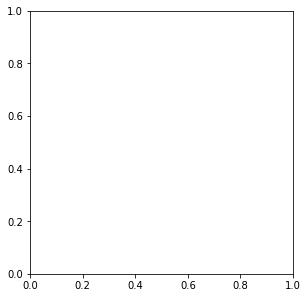

In [38]:
NB3_so = create_images(NB3_cat, 'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits', 'NB3') #!!!!! Different path (cal2)
MB3_so = create_images(MB3_cat, 'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits', 'MB3')
NB6_so = create_images(NB6_cat, 'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor.fits',   'NB6')
MB6_so = create_images(MB6_cat, 'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor.fits',  'MB6')

In [53]:
len(RadioSource.get_snr(MB3_so, catalog=NB3_cat))

410

In [54]:
#NB3_cat_snr = RadioSource.get_snr(NB3_so, catalog=NB3_cat)
#MB3_cat_snr = RadioSource.get_snr(MB3_so, catalog=MB3_cat)
#NB6_cat_snr = RadioSource.get_snr(NB6_so, catalog=NB6_cat)
#MB6_cat_snr = RadioSource.get_snr(MB6_so, catalog=MB6_cat)

In [55]:
#NB3_cat.add_column(NB3_cat_snr,name='SNR')
#MB3_cat.add_column(MB3_cat_snr,name='SNR')
#NB6_cat.add_column(NB6_cat_snr,name='SNR')
#MB6_cat.add_column(MB6_cat_snr,name='SNR')

In [56]:
MB3_cat

_idx,c_ID,_name,area_ellipse,area_exact,flux,peak,npix,major_fwhm,minor_fwhm,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,x_cen_px,y_cen_px,radial_d_px,radial_d_AU,rejected,100.0GHz_snr,SNR
int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
941,0,1,9.113530739610145e-10,3.2250000000000003e-09,0.015264973732168265,0.005653016269207001,129,4.1502301268614775e-05,2.795966711985743e-05,1.762440461477782e-05,1.1873377406845523e-05,105.63457894981724,1.4465863526323167e-05,266.8338108589449,-28.38511168227036,3115.7927087407616,2982.3314207102258,99.79105897173206,15268.032022654985,0.0,28.912640051130776,28.912640051130776
951,0,2,1.0264472348167841e-09,1.0075000000000001e-08,0.1595143384253843,0.08008609712123871,403,3.771986813279909e-05,3.46484631233892e-05,1.6018153154587802e-05,1.4713847538584978e-05,-141.28073667494058,1.53521550072395e-05,266.8340751794522,-28.384996254144223,3069.2843424188454,3005.417090979457,66.63826655710653,10195.654783262353,0.0,301.0792404313873,301.0792404313873
956,0,3,7.703065025717809e-10,2.0750000000000004e-09,0.0060525787305992385,0.00238540256395936,83,5.319656543864369e-05,1.8437306813217034e-05,2.2590501363744136e-05,7.829603307532025e-06,136.4483858217243,1.3299423453532782e-05,266.833878957661,-28.38504390588987,3103.8104585142537,2995.8867181680093,82.49325391886961,12621.467849791314,0.0,7.082457650078901,7.082457650078901
976,0,4,1.00978224826943e-09,3.2000000000000005e-09,0.0017340863365012172,0.0005110484780743718,128,4.4717174560375485e-05,2.8752187309033435e-05,1.8989635600705857e-05,1.2209929743763306e-05,164.14553470869066,1.5227019292832233e-05,266.8337884105155,-28.384954895311775,3119.7426798604693,3013.688803901498,75.3628494067018,11530.515959185921,0.0,3.567233673525352,3.567233673525352
980,0,5,2.0161034980787117e-09,7.475e-09,0.01120607321311016,0.002279166132211685,299,5.76282814226749e-05,4.454455936012462e-05,2.4472477862705425e-05,1.8916332674388786e-05,69.437231953366,2.1515797280546006e-05,266.83395692244784,-28.384912521599762,3090.0922227810534,3022.1635923312465,53.01882735864175,8111.880586337012,0.0,16.900368264066227,16.900368264066227
992,0,6,4.250840667671987e-10,2.3000000000000003e-09,0.008732593311667723,0.00767515879124403,92,2.619168262262213e-05,2.0664692142725018e-05,1.1122583518808926e-05,8.775486766528447e-06,138.300605966283,9.879579165071512e-06,266.83364508127164,-28.38482823156954,3144.9622192662755,3039.0214805783853,80.06914626435004,12250.579378359278,0.0,43.06132798561846,43.06132798561846
1010,0,7,4.6256085792664425e-10,1.5000000000000002e-09,0.05181423302190518,0.030489187687635422,60,3.065390715408036e-05,1.9213237647847484e-05,1.301751580498266e-05,8.159110794215685e-06,175.73616890772465,1.030588927353226e-05,266.8339686623299,-28.384745833885958,3088.0265598820783,3055.5011367492953,23.001371920372456,3519.209903759988,0.0,23.106819136960326,23.106819136960326
1017,0,8,5.3687076781288415e-11,1.7500000000000002e-10,0.020104845042894164,0.07252375781536102,7,1.2198523648841678e-05,5.603766072817842e-06,5.180236033145095e-06,2.379700344679286e-06,171.61563369233028,3.5110410811603215e-06,266.8340752198644,-28.38472620957402,3069.277224770719,3059.4260050209646,12.865413117424364,1968.4082072570657,0.0,2.043497638293629,2.043497638293629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
